# Feature Set Comparison

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/business_closures_data.csv')
data.head()

,Percent Change in Number of Small Businesses Open,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,-39.70,19089,Iowa,Howard,99,5608.073753,12.622644,3.160173,3.574778,6.971154,...,9.6,58028.0,11.560510,2.8,26.448363,5.143541,31.287879,16.264805,0,1021
1,-1.01,31177,Nebraska,Washington,195,4632.870334,11.720313,2.750393,3.175809,6.013514,...,6.8,75197.0,21.067497,2.9,29.484214,6.721927,32.813006,12.265953,0,1148
2,-5.51,31159,Nebraska,Seward,207,5410.847151,12.026406,2.968235,3.218111,6.212121,...,7.2,72291.0,19.126991,2.9,34.388775,7.529180,33.000000,11.688027,0,4330
3,-1.59,31145,Nebraska,Red Willow,137,6658.414878,14.776613,3.288232,3.690134,6.571742,...,12.0,50260.0,11.779891,2.8,32.797243,11.402280,34.854962,16.237970,0,825
4,-19.20,31141,Nebraska,Platte,309,5279.823593,14.422556,3.001068,3.286868,5.771531,...,9.0,62804.0,14.510795,2.9,30.711008,7.532143,31.196560,10.707512,1,2085


In [4]:
X = data.drop(["FIPS", "Percent Change in Number of Small Businesses Open", "State", "County"], axis=1)
y = pd.DataFrame(data["Percent Change in Number of Small Businesses Open"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Dummy Baseline

In [7]:
y_train_mean = y_train.mean()
y_train_mean

Percent Change in Number of Small Businesses Open   -28.698727
dtype: float64

In [8]:
(((y_test - y_train_mean)**2).sum())**(.5)

Percent Change in Number of Small Businesses Open    247.125585
dtype: float64

## MLP: XGBoost Most Important Features

In [89]:
X_train_x = X_train.filter(['% Jobs in Leisure and Hospitality', '% Excessive Drinking', 
                '% Long Commute - Drives Alone', '% Asian', 
                '% American Indian & Alaska Native', 'Income Ratio', 'Social Association Rate',
                'Primary Care Physicians Rate'])

X_val_x = X_val.filter(['% Jobs in Leisure and Hospitality', '% Excessive Drinking', 
                '% Long Commute - Drives Alone', '% Asian', 
                '% American Indian & Alaska Native', 'Income Ratio', 'Social Association Rate',
                'Primary Care Physicians Rate'])

X_test_x = X_test.filter(['% Jobs in Leisure and Hospitality', '% Excessive Drinking', 
                '% Long Commute - Drives Alone', '% Asian', 
                '% American Indian & Alaska Native', 'Income Ratio', 'Social Association Rate',
                'Primary Care Physicians Rate'])

In [90]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [91]:
train_data_x = PrepareData(X_train_x, y_train)
val_data_x = PrepareData(X_val_x, y_val)
test_data_x = PrepareData(X_test_x, y_test)

In [92]:
batch_size = 8

In [93]:
train_loader_x = DataLoader(train_data_x, 
                          batch_size)

valid_loader_x = DataLoader(val_data_x, 
                          batch_size)

test_loader_x = DataLoader(test_data_x, 
                         batch_size)

In [94]:
class MLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [97]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [98]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(25):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_x.model')

Epoch: 1 	Training Loss: 24.750111 	Validation Loss: 14.881772
Epoch: 2 	Training Loss: 15.659070 	Validation Loss: 14.417506
Epoch: 3 	Training Loss: 15.330761 	Validation Loss: 14.090696
Epoch: 4 	Training Loss: 15.303445 	Validation Loss: 13.946074
Epoch: 5 	Training Loss: 14.949399 	Validation Loss: 13.787590
Epoch: 6 	Training Loss: 14.595635 	Validation Loss: 13.835905
Epoch: 7 	Training Loss: 14.632115 	Validation Loss: 13.875999
Epoch: 8 	Training Loss: 14.375881 	Validation Loss: 13.927847
Epoch: 9 	Training Loss: 14.297443 	Validation Loss: 13.965539
Epoch: 10 	Training Loss: 14.191061 	Validation Loss: 13.929688
Epoch: 11 	Training Loss: 14.129726 	Validation Loss: 14.058999
Epoch: 12 	Training Loss: 13.510833 	Validation Loss: 13.938176
Epoch: 13 	Training Loss: 13.777638 	Validation Loss: 14.045716
Epoch: 14 	Training Loss: 13.757763 	Validation Loss: 13.999654
Epoch: 15 	Training Loss: 13.514413 	Validation Loss: 13.965367
Epoch: 16 	Training Loss: 13.566763 	Validation L

In [99]:
best_val_loss

13.78758961115128

In [100]:
mlp.load_state_dict(torch.load('mlp_x.model'))

In [101]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)
    
test_loss = test_loss/len(test_data_x)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 13.145304



### Explain output through SHAP

In [102]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_x.model'))

In [103]:
x_x, _ = next(iter(train_loader_x))

In [104]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x)

shap_values = explainer_shap.shap_values(X=x_x,
                                      ranked_outputs=True)

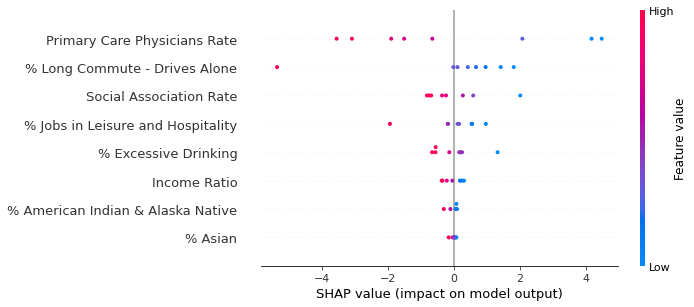

In [105]:
shap.summary_plot(shap_values, x_x, feature_names=X_train_x.columns)

## MLP: Original Features

In [106]:
X_train_o = X_train.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

X_val_o = X_val.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

X_test_o = X_test.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

In [107]:
train_data_o = PrepareData(X_train_o, y_train)
val_data_o = PrepareData(X_val_o, y_val)
test_data_o = PrepareData(X_test_o, y_test)

In [108]:
train_loader_o = DataLoader(train_data_o, 
                          batch_size)

valid_loader_o = DataLoader(val_data_o, 
                          batch_size)

test_loader_o = DataLoader(test_data_o, 
                         batch_size)

In [133]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [134]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(25):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_o.model')

Epoch: 1 	Training Loss: 28.989242 	Validation Loss: 15.673276
Epoch: 2 	Training Loss: 14.679858 	Validation Loss: 16.061638
Epoch: 3 	Training Loss: 14.395560 	Validation Loss: 15.644916
Epoch: 4 	Training Loss: 14.328207 	Validation Loss: 15.807739
Epoch: 5 	Training Loss: 14.280052 	Validation Loss: 15.957040
Epoch: 6 	Training Loss: 14.154456 	Validation Loss: 16.112333
Epoch: 7 	Training Loss: 14.258966 	Validation Loss: 16.299730
Epoch: 8 	Training Loss: 14.273662 	Validation Loss: 15.347389
Epoch: 9 	Training Loss: 14.142798 	Validation Loss: 16.048303
Epoch: 10 	Training Loss: 14.113195 	Validation Loss: 15.913810
Epoch: 11 	Training Loss: 14.108180 	Validation Loss: 16.007550
Epoch: 12 	Training Loss: 14.043882 	Validation Loss: 15.993953
Epoch: 13 	Training Loss: 14.084822 	Validation Loss: 16.085279
Epoch: 14 	Training Loss: 14.019273 	Validation Loss: 16.516078
Epoch: 15 	Training Loss: 14.132784 	Validation Loss: 16.225751
Epoch: 16 	Training Loss: 14.027849 	Validation L

In [135]:
best_val_loss

15.347389294550968

In [136]:
mlp.load_state_dict(torch.load('mlp_o.model'))

In [137]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 14.483153



### Explain output through SHAP

In [138]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_o.model'))

In [139]:
x_o, _ = next(iter(train_loader_o))

In [140]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o)

shap_values = explainer_shap.shap_values(X=x_o,
                                      ranked_outputs=True)

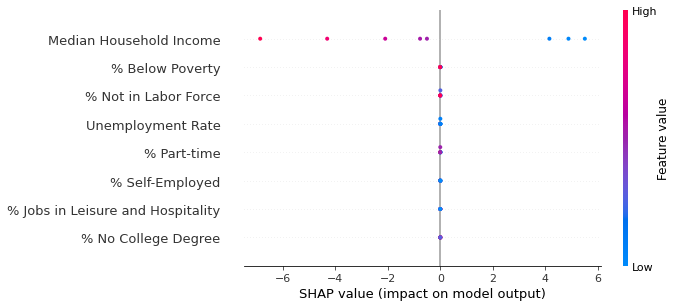

In [141]:
shap.summary_plot(shap_values, x_o, feature_names=X_train_o.columns)

## MLP: Original Features + 'Primary Care Physicians Rate'

In [156]:
X_train_o2 = X_train.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed', 'Primary Care Physicians Rate'])

X_val_o2 = X_val.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed', 'Primary Care Physicians Rate'])

X_test_o2 = X_test.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed', 'Primary Care Physicians Rate'])

In [157]:
train_data_o2 = PrepareData(X_train_o2, y_train)
val_data_o2 = PrepareData(X_val_o2, y_val)
test_data_o2 = PrepareData(X_test_o2, y_test)

In [158]:
train_loader_o2 = DataLoader(train_data_o2, 
                          batch_size)

valid_loader_o2 = DataLoader(val_data_o2, 
                          batch_size)

test_loader_o2 = DataLoader(test_data_o2, 
                         batch_size)

In [177]:
mlp = MLP(input_dim=9)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [178]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(25):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o2:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o2:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_o2.model')

Epoch: 1 	Training Loss: 24.145799 	Validation Loss: 15.913933
Epoch: 2 	Training Loss: 18.576279 	Validation Loss: 15.304281
Epoch: 3 	Training Loss: 17.270537 	Validation Loss: 15.454432
Epoch: 4 	Training Loss: 15.964243 	Validation Loss: 15.138522
Epoch: 5 	Training Loss: 15.544519 	Validation Loss: 15.693113
Epoch: 6 	Training Loss: 15.397204 	Validation Loss: 14.884253
Epoch: 7 	Training Loss: 15.976342 	Validation Loss: 14.812587
Epoch: 8 	Training Loss: 15.425532 	Validation Loss: 14.848147
Epoch: 9 	Training Loss: 14.805107 	Validation Loss: 15.296559
Epoch: 10 	Training Loss: 14.653857 	Validation Loss: 14.847310
Epoch: 11 	Training Loss: 14.530157 	Validation Loss: 14.980790
Epoch: 12 	Training Loss: 14.424865 	Validation Loss: 15.320065
Epoch: 13 	Training Loss: 14.225530 	Validation Loss: 15.101075
Epoch: 14 	Training Loss: 14.139538 	Validation Loss: 15.170829
Epoch: 15 	Training Loss: 14.270644 	Validation Loss: 15.306754
Epoch: 16 	Training Loss: 14.150133 	Validation L

In [179]:
best_val_loss

14.812586833269169

In [180]:
mlp.load_state_dict(torch.load('mlp_o2.model'))

In [181]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o2:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o2)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 13.758719



### Explain output through SHAP

In [182]:
mlp = MLP(input_dim=9)
mlp.load_state_dict(torch.load('mlp_o2.model'))

In [183]:
x_o2, _ = next(iter(train_loader_o2))

In [184]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o2)

shap_values = explainer_shap.shap_values(X=x_o2,
                                      ranked_outputs=True)

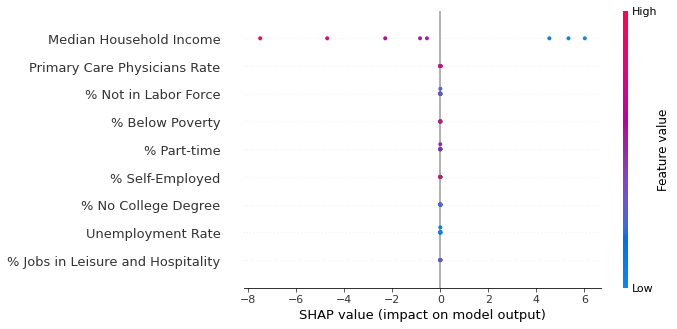

In [185]:
shap.summary_plot(shap_values, x_o2, feature_names=X_train_o2.columns)